次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業の潜在価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [67]:
using StatsPlots
using Random
using Statistics

In [68]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost   #   取得原価のリスト
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.01*firms[i].hiddenCorporateValue + 0.99*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    buy, sell = [], []
    marketCap, estimated_value, α, β = 0.0, 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        α, β = agent.params[2], agent.params[3]
        estimated_value = agent.fundamentals[i]
        if α*estimated_value > marketCap
            push!(buy, (α - marketCap/estimated_value, i))  #   α - marketCap/estimated_value が大きいほど買いたい
        elseif β*estimated_value < marketCap && agent.sharesQuantity[i] > 0.0
            push!(sell, (marketCap/estimated_value - β, i)) #   marketCap/estimated_value - β が大きいほど売りたい
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_sell_price, going_to_buy_price, k = 0.0, 0.0, 0
    #   戦略的な売り。調査に労力がかかることを考慮し、１期に１銘柄しか選べないという制限をかける
    if size(sell)[1] > 0
        x, k = pop!(sell)
        marketCap = firms[k].marketCapitalization
        stockQuantity = firms[k].stockQuantity
        quantity = agent.sharesQuantity[k]
        if quantity > 0.0
            price = (estimated_value + marketCap)/(2*stockQuantity)
            push!(firms[k].sell_offers, (price, quantity, j))
            going_to_sell_price += price * quantity
        end
    end
    #   ポートフォリオ配分を調整するための売り。際限なく売れる
    flug = true
    lst = []
    while agent.money + going_to_sell_price < agent.portfolio_target[1]
        if flug
            flug = false
            for (i, q) in enumerate(agent.sharesQuantity)
                if q > 0.0 && i != k
                    push!(lst, (i,q))
                end
            end
            shuffle(lst)
        end
        if size(lst)[1] == 0
            break
        end
        i, quantity = pop!(lst)
        price = firms[i].stockPrice
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
    end
    #   戦略的な買い。調査に労力がかかることを考慮し、１期に１銘柄しか選べないという制限をかける
    if size(buy)[1] > 0
        _, i = pop!(buy)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        price = (estimated_value + marketCap)/(2*stockQuantity)
        quantity = 1/agent.params[end]*agent.money/price
        push!(firms[i].buy_offers, (price, quantity, j))
        going_to_buy_price += price * quantity
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (-p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if going_to_buy_price > agent.money
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1-p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = agent.sharesQuantity[i]
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1])/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p/agents[js].purchase_cost[i] - 1)
            end                    
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    performance10_lst = []
    for (j, agent) in enumerate(agents)
        performance10 = (agent.total_assets_log[end] - agent.total_assets_log[end-9])/agent.total_assets_log[end-9]
        push!(performance10_lst, (performance10, j))
    end
    sort!(performance10_lst)
    A = Int(floor(size(agents)[1]/10))
    best_agents = [pop!(performance10_lst)[2] for _ = 1:A]
    for agent in agents
        teacher = rand(best_agents)
        if rand() < 0.02 - agent.performance
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "fundamentals"
            agent.params[2] += 0.01*randn()
            agent.params[3] += 0.01*randn()
            if agent.params[2] < 0
                agent.params[2] = abs(agent.params[2] % 1)
            end
            if agent.params[3] < 0
                agent.params[3] = abs(agent.params[3] % 1)
            end
            if agent.params[2] > agent.params[3]
                agent.params[2], agent.params[3] = agent.params[3], agent.params[2]
            end
        elseif agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [69]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_money = 100.0*M/N
agents = [
    Agent(
        "chart",
        init_money,
        [1.0 for _ = 1:M],
        [1.0 for _ = 1:M],
        [2.0*init_money],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [1.0 for _ = 1:M],
            [1.0 for _ = 1:M],
            [2.0*init_money],
            [0.9, 0.9, 1.1, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        1.0,
        100.0,
        [1.0],
        [100.0],
        100.0,
        100.0,
        [],
        [],
    ) for _ = 1:M
]

@time for t = 1:200
    income = 0.1*init_money
    run_one_term(agents, firms, income)
end

  2.117740 seconds (11.62 M allocations: 265.928 MiB, 4.02% gc time, 40.61% compilation time)


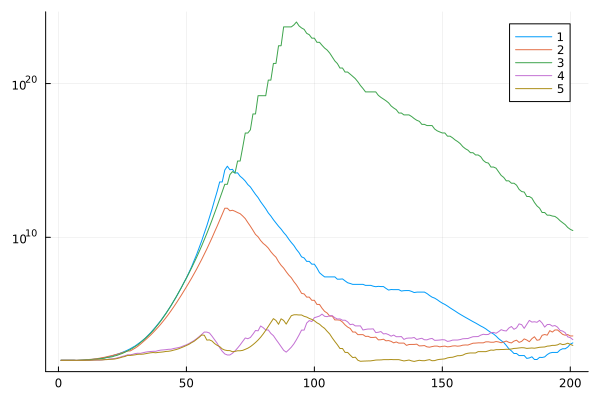

In [70]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

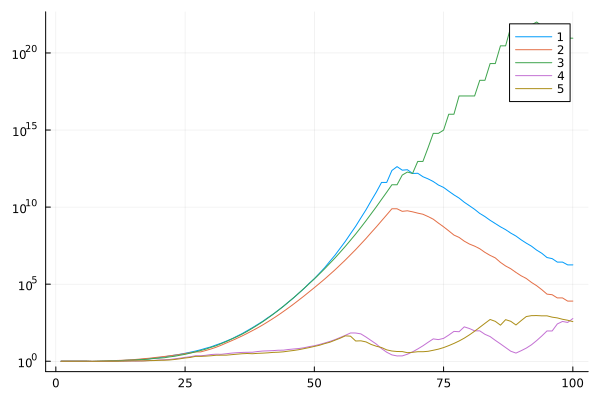

In [71]:
plot(firms[1].stockPriceLog[1:100], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100], label=string(5), yscale=:log10)

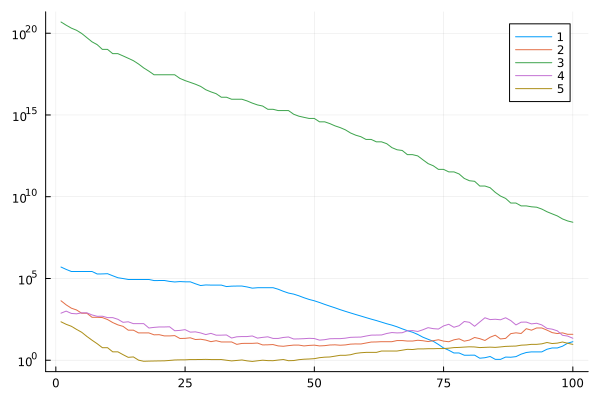

In [72]:
plot(firms[1].stockPriceLog[end-99:end], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end], label=string(5), yscale=:log10)

In [73]:
agents

100-element Vector{Agent}:
 Agent("chart", 24.834940386276752, [0.0, 0.0984978389789032, 1.5579863520224903e-8, 0.08704336331005108, 0.8978853187025395, 0.03477743724632825, 2.2106911513579623, 0.02449707669530036, 0.3675178635411158, 2.670797590858547], [0.0, 3.776552466010427, 4.287611274961034, 1.917543281889592, 8.34693603209715, 5.052044855728647, 22.540620150553803, 1.613077203855349, 5.384056118129754, 8.463750163424987], [20.0, 20.698379639317597, 22.397253083828755, 24.098468846535006, 25.800952434947583, 27.505921949539644, 28.699606471953306, 29.706443512875367, 30.706443512875367, 31.706443512875367  …  102.02501352832489, 100.69523636736103, 101.52766289043078, 97.73024117278513, 97.51119766209766, 91.88478494205874, 89.36629668865945, 87.9602283963282, 85.7071233459214, 85.2171319329275], [0.8603177238428853, 2.0, 0.04894707965998014, -0.6091942530542599, 0.11359773715920397, 0.6182744366384286, -0.09257068523636355, 0.1603689291544351, -0.03204851071552098, 0.00586721492

In [74]:
firms

10-element Vector{Firm}:
 Firm(13.568968409933841, 100.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9750535438126327, 0.9889751525760304, 1.0047688598902198, 1.017092533986062  …  2.9662199643462466, 3.2372490064884496, 3.2372490064884496, 3.2372490064884496, 4.681457085603485, 5.609011816339013, 5.609011816339013, 7.1820365325745845, 11.005003487551125, 13.568968409933841], [100.0], 1356.896840993384, 100.14804542189314, Any[(12.111060857041007, 0.125907963808933, 8), (12.159980103417046, 0.10651059491542073, 1), (12.543522892495007, 0.5302266280546681, 70), (12.579484617630152, 0.6115519637761896, 27), (12.653345707255292, 0.16065327815510635, 52), (12.796702427371327, 0.04426304195083695, 49), (12.839905009290376, 2.630372774878211, 38), (13.096717237861819, 0.10936165023066255, 77), (13.183362097675108, 0.23158971475599216, 57), (14.444020962044224, 0.8449964395641805, 42), (14.647529152756878, 0.23377799648524925, 25), (14.65568171064339, 0.7768376570892609, 69), (14.946366711318802, 0.556

In [75]:
money_sum = 0
for agent in agents
    money_sum += agent.money
end
money_sum

32926.27800634055

In [76]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

100.14804542189314
91.6930101259449
98.7784125795235
118.3534806857055
108.93100376823772
127.92614099300735
84.26426407322082
90.19263369414872
106.4186063698057
62.51784560168617


In [77]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

1356.896840993384
3834.1475357843224
2.752021074764293e10
2202.9747116494627
929.6216185112172
14526.788791091943
1019.6186896893203
6584.77427294339
1464.978073787539
316.89972285411017


In [78]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[86.57867954555272, 118.05454314575358, 99.38278678363923, 109.26391569334741, 110.17024418587647, 116.52196592140294, 100.31275772794973, 98.31482313278933, 94.32128655003434, 64.576205915195]
[94.64403653612978, 122.29842899367868, 83.18963682906265, 108.33658932372397, 116.04458335981735, 103.59695509159752, 98.70487672541438, 94.05560989260175, 118.33795855710719, 75.27434000964357]
[99.68851661072902, 108.6733586249495, 99.49765842328765, 96.7857150946813, 106.55388369270419, 118.53530086968762, 92.8361876964609, 88.02509702760335, 119.09805913470447, 63.41135251257633]
[99.88168537580482, 109.61718859029679, 95.72261887665753, 98.29168126881726, 98.329815392008, 118.91509424155977, 94.85114052380024, 98.59413676375492, 104.25478813217417, 68.32462676411657]
[105.0448335253149, 133.86982343597714, 83.22190353451543, 113.22437645615517, 94.48126210616006, 109.85804308790891, 100.68290978225616, 92.58305756062016, 99.42518063645673, 64.529641078884]
[106.22482085150143, 117.30170983

In [79]:
for agent in agents[1:10]
    println(agent.params)
end

[0.8603177238428853, 2.0, 0.04894707965998014, -0.6091942530542599, 0.11359773715920397, 0.6182744366384286, -0.09257068523636355, 0.1603689291544351, -0.03204851071552098, 0.0058672149203438835, 0.499790093406155, 22.0]
[0.8633352658135599, 0.9859844190802757, 1.206507743045325, 15.0]
[0.7677018401812807, 0.8977065920741806, 1.1411846271038784, 14.0]
[0.7661433747911875, 0.9916141732613459, 1.4430811348279602, 25.0]
[0.6957790598546102, 1.0, -0.06651635222093387, -0.8376246025472743, 0.9998994951942938, -0.27556578170137164, 1.734798508127499, -0.09877383952970638, -0.09430097894911348, 0.16765034816876356, 0.5746157762573564, 44.0]
[0.8282273785597221, 1.1080555059292425, 1.1707903799345536, 17.0]
[0.7818556280275905, 1.0, -0.11777843849723807, -0.7870863640395691, 0.9645551333768263, -0.264575410253202, 1.817975319071607, -0.051765965341390004, -0.09239261437280351, 0.011408933897955572, 0.683317845321628, 35.0]
[0.9570468763995227, 2.0, 0.11658863494529935, -0.5580548441822953, 0.1

In [80]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.0, 0.0984978389789032, 1.5579863520224903e-8, 0.08704336331005108, 0.8978853187025395, 0.03477743724632825, 2.2106911513579623, 0.02449707669530036, 0.3675178635411158, 2.670797590858547]
[0.0, 0.0, 0.9999998570016513, 0.0, 0.35544999475403405, 0.5683279798111669, 0.0, 0.45712082041653385, 0.1750441634760621, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.8879392434089057, 6.083037357892964, 10.02670559327243, 1.626163118641466, 0.6185970442324717, 0.15268795781806446, 0.0, 1.1247491725097851, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6281657075010066, 0.45320638636960164, 2.5422316393870266e-9, 0.3101324307817204, 0.13567233202757842, 0.6734782533091261, 0.0, 

0.1443024026684506, 0.07294593052073547, 0.6003758477787757]
[0.0, 0.0658811701985492, 5.595215218455736e-9, 0.08137253297126067, 0.6271139050526421, 0.02331817353807268, 0.2145721599589662, 0.010978502606942187, 0.24767382827696613, 0.33756312306042974]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.3686458701727462, 0.5020273704385289, 1.9566352828631017e-9, 0.1488997368063661, 0.0, 1.5139458928545313, 0.0, 0.017866325363834333, 0.0734211991837018, 0.0]


In [81]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
